# 2020 November 28 - PSF Subtraction

In [1]:
using ADI
using CSV
using DataFrames
using PlotUtils
using ProgressMeter
using PSFModels: Gaussian
using PyCall
using PyPlot
using SAOImageDS9
using SiriusB
using Statistics

In [2]:
# python imports
hp = pyimport("hciplot")
fits = pyimport("astropy.io.fits");

In [3]:
# set up DS9 connection
DS9.connect()

"7f000001:62503"

In [4]:
parallax = 376.6801e-3 # arcseconds
pxscale = 0.01
auscale = pxscale / parallax;

In [5]:
# build this plotting command because hciplot doesn't respect default cmap
# nor has built-in zscale support
function plot_frames(frames...; cmap="inferno", zscale=false, kwargs...)
    data = Matrix.(Tuple(frames))
    if zscale
        clims = map(PlotUtils.zscale, data)
        vmin = map(first, clims)
        vmax = map(last, clims)
    else
        vmin = vmax = nothing
    end
    hp.plot_frames(
        data; cmap=cmap, vmin=vmin, vmax=vmax, 
        horsp=0.25, versp=0, pxscale,
        ang_scale=true, auscale,
        au_legend=true, kwargs...
    )
end

plot_frames (generic function with 1 method)

In [6]:
# set up path for processing of this epoch
procdir(args...) = datadir("epoch_2020nov28", "processed", args...)
mkpath(procdir());

In [7]:
cube = fits.getdata(procdir("2020nov28_sirius-b_cube_calib_registered_crop.fits"))
angles = fits.getdata(procdir("2020nov28_sirius-b_pa.fits"));

In [8]:
raw_median = collapse(cube)
raw_collapsed = collapse(cube, angles);

In [9]:
psf_params = gaussian_fit(raw_median, (100.5, 100.5))
fwhm = psf_params[3]
@show fwhm
psf_model = Gaussian{eltype(cube)}(psf_params[1:2], fwhm)[axes(raw_median)...];

fwhm = 8.216162087416189


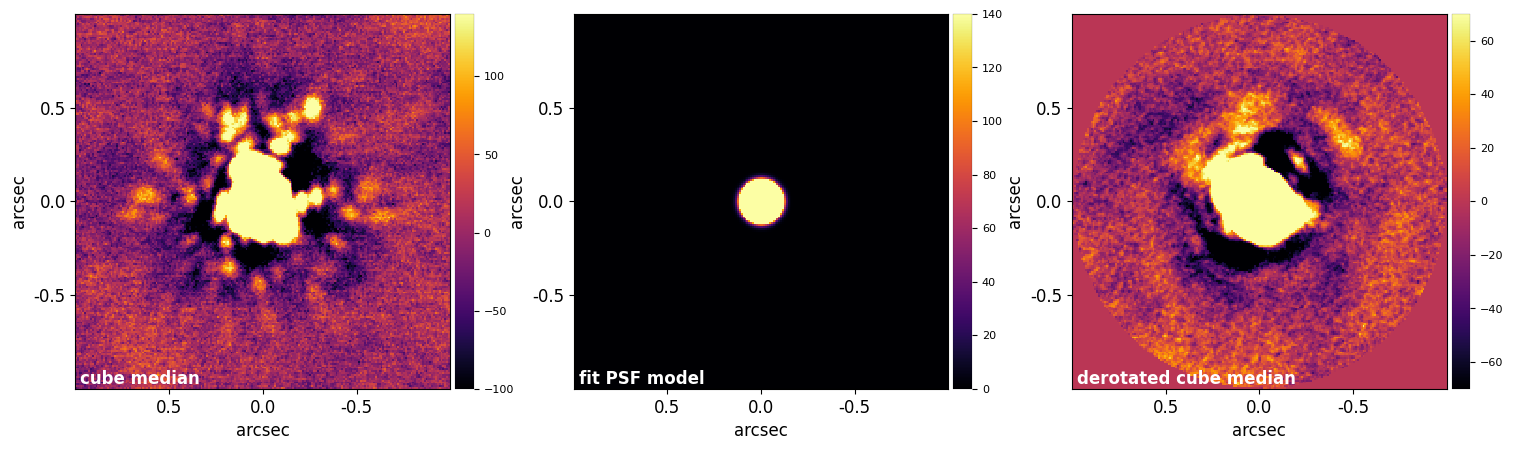

In [10]:
plot_frames(
    raw_median, exp(psf_params[4]) .* psf_model, raw_collapsed;
    vmin=(-100, 0, -70), vmax=(140, 140, 70),
    label=("cube median", "fit PSF model", "derotated cube median")
)

In [11]:
results = Dict{Symbol, typeof(cube)}();

## Median Subtraction

In [12]:
med_residual_cube = subtract(Classic(), cube)
push!(results, :median => med_residual_cube);

In [13]:
med_residual = collapse(med_residual_cube, angles)
med_snr = detectionmap(med_residual, fwhm)
med_stim = stimmap(med_residual_cube, angles);

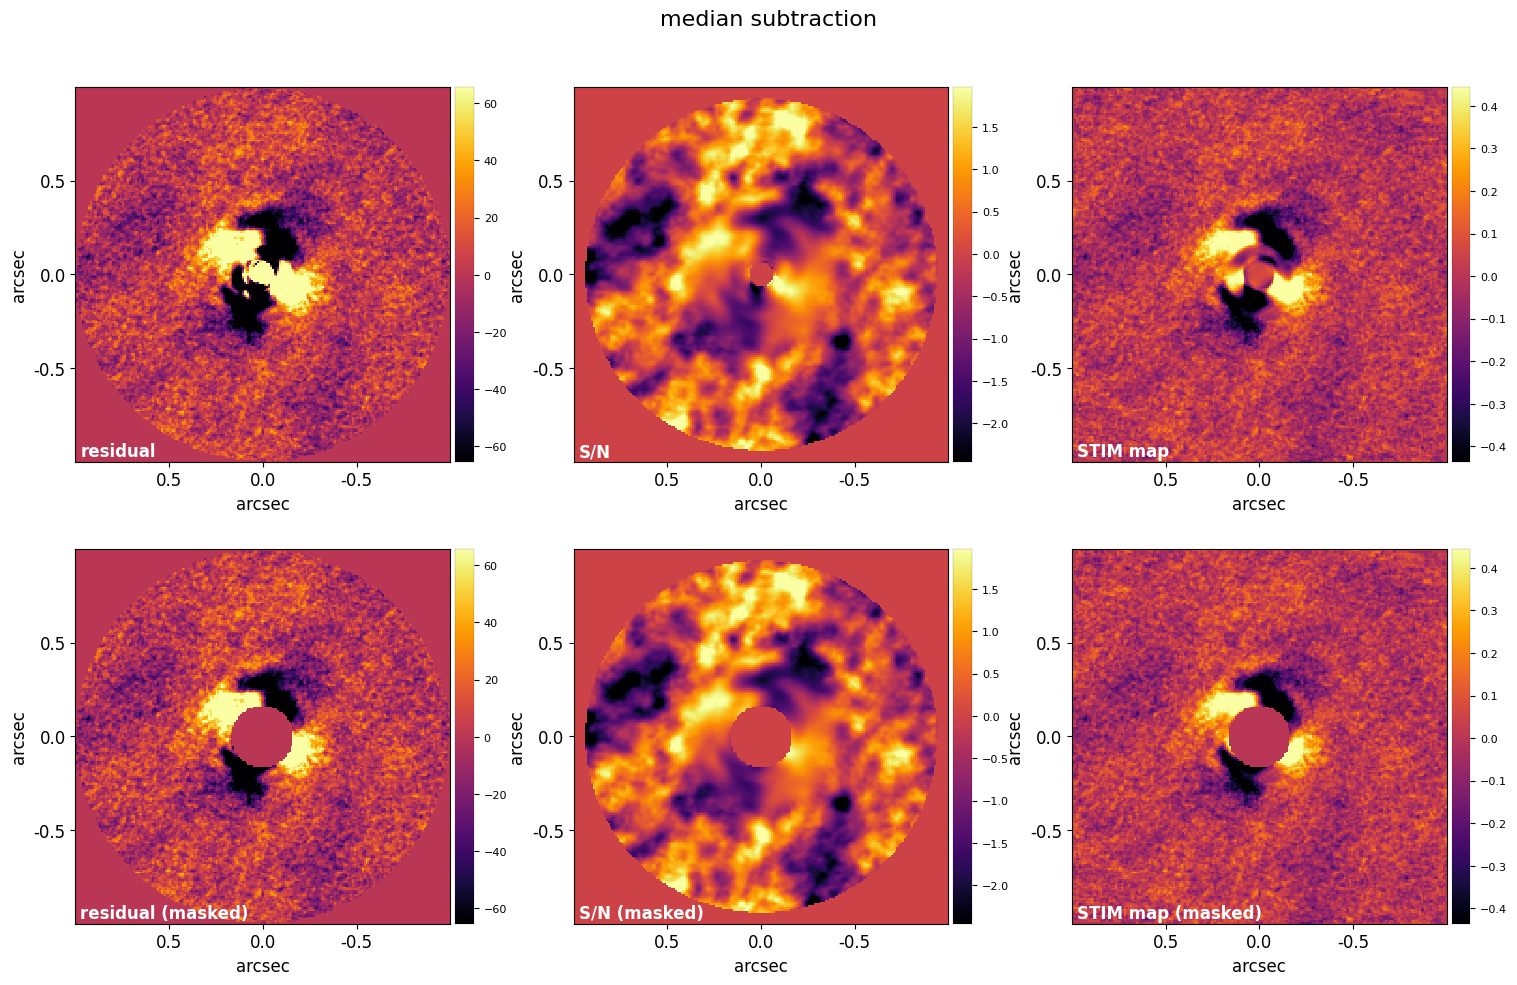

In [14]:
plot_frames(
    med_residual, med_snr, med_stim,
    mask_circle.((med_residual, med_snr, med_stim), 2 * fwhm)...;
    zscale=true, rows=2,
    title="median subtraction",
    label=("residual", "S/N", "STIM map",
           "residual (masked)", "S/N (masked)", "STIM map (masked)"),
)

## Annular median subtraction

In [15]:
ann_cube = MultiAnnulusView(cube, fwhm; inner=fwhm);

### without rotation threshold

In [16]:
ann_med_residual_cube = subtract(Classic(), ann_cube)
push!(results, :annular_median => ann_med_residual_cube);

In [17]:
ann_med_residual = collapse(ann_med_residual_cube, angles)
ann_med_snr = detectionmap(ann_med_residual, fwhm)
ann_med_stim = stimmap(ann_med_residual_cube, angles);

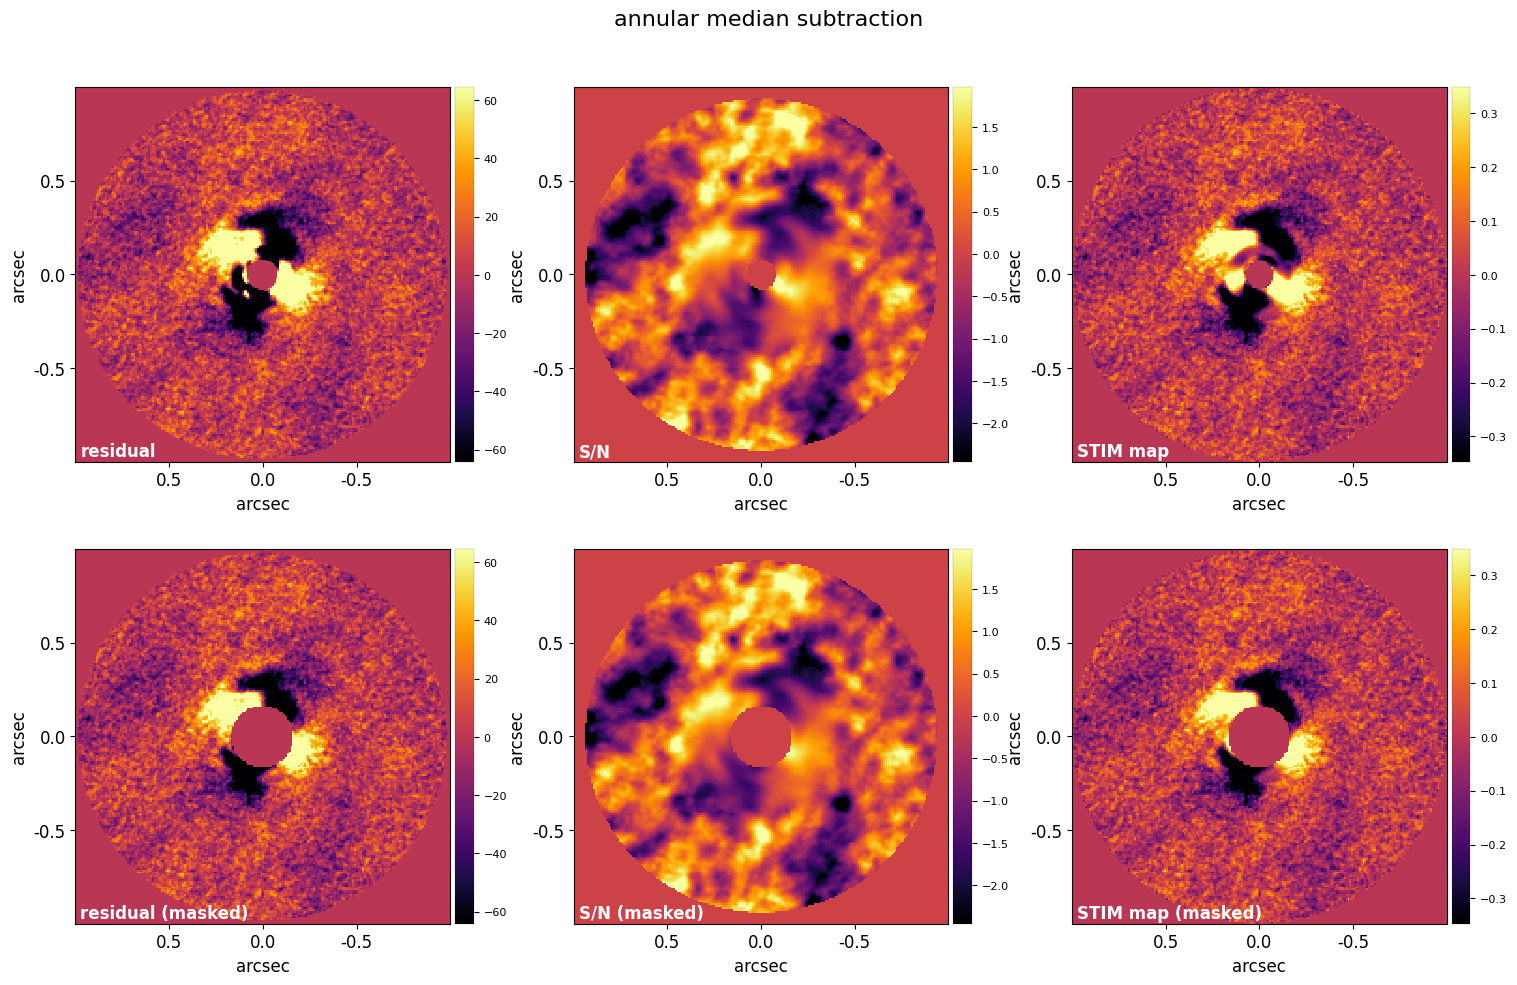

In [18]:
plot_frames(
    ann_med_residual, ann_med_snr, ann_med_stim,
    mask_circle.((ann_med_residual, ann_med_snr, ann_med_stim), 2 * fwhm)...;
    zscale=true, rows=2,
    title="annular median subtraction",
    label=("residual", "S/N", "STIM map",
           "residual (masked)", "S/N (masked)", "STIM map (masked)"),
)

### with rotation threshold

In [19]:
ann_med_drot_residual_cube = subtract(Framewise(Classic(), delta_rot=1), ann_cube; angles)
push!(results, :annular_median_drot => ann_med_drot_residual_cube);

┌ Info: pa threshold 36.86989764584402 too large, will be set to 36.173437216177774
└ @ ADI /Users/miles/.julia/packages/ADI/iopa7/src/framewise.jl:140


In [20]:
ann_med_drot_residual = collapse(ann_med_drot_residual_cube, angles)
ann_med_drot_snr = detectionmap(ann_med_drot_residual, fwhm)
ann_med_drot_stim = stimmap(ann_med_drot_residual_cube, angles);

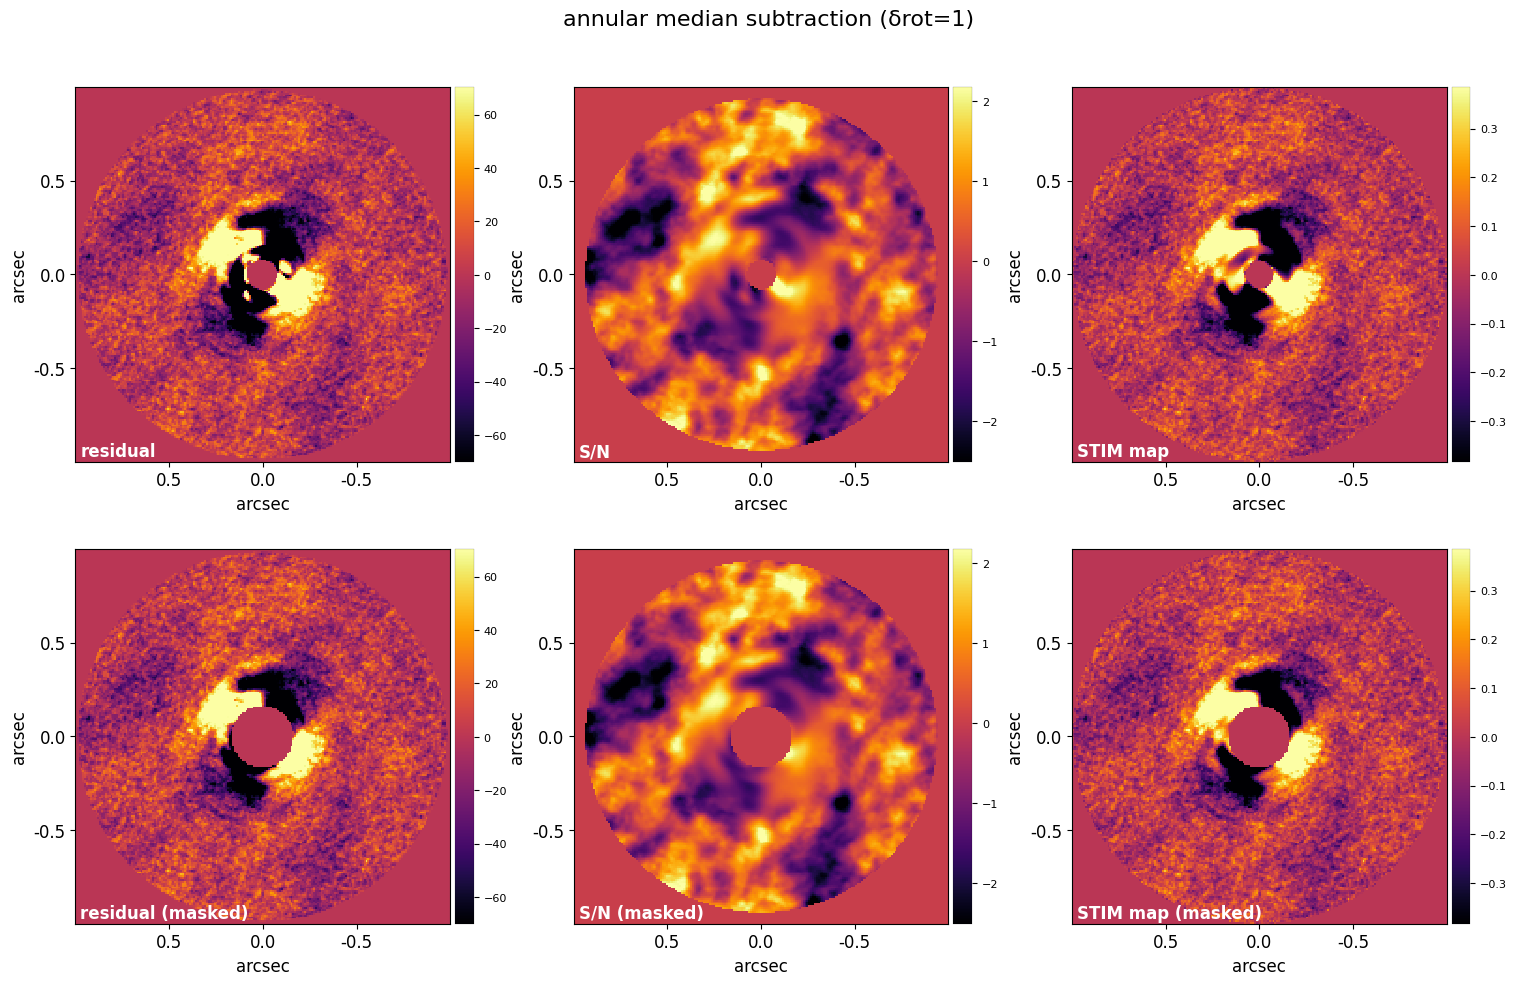

In [21]:
plot_frames(
    ann_med_drot_residual, ann_med_drot_snr, ann_med_drot_stim,
    mask_circle.((ann_med_drot_residual, ann_med_drot_snr, ann_med_drot_stim), 2 * fwhm)...;
    zscale=true, rows=2,
    title="annular median subtraction (δrot=1)",
    label=("residual", "S/N", "STIM map",
           "residual (masked)", "S/N (masked)", "STIM map (masked)"),
)

## PCA (KLIP) Subtraction

In [22]:
max_ncomp = 30
pca_Z, pca_w = ADI.fit(PCA(max_ncomp), cube)
pca_residual_cubes = @showprogress map(1:max_ncomp) do ncomp
    S = @views pca_w[:, 1:ncomp] * pca_Z[1:ncomp, :]
    S_cube = ADI.expand_geometry(cube, S)
    return cube .- S_cube
end
pca_residual_frames = collapse.(pca_residual_cubes, Ref(angles));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


In [23]:
DS9.set(permutedims(cat(pca_residual_frames..., dims=3), (2, 1, 3)))

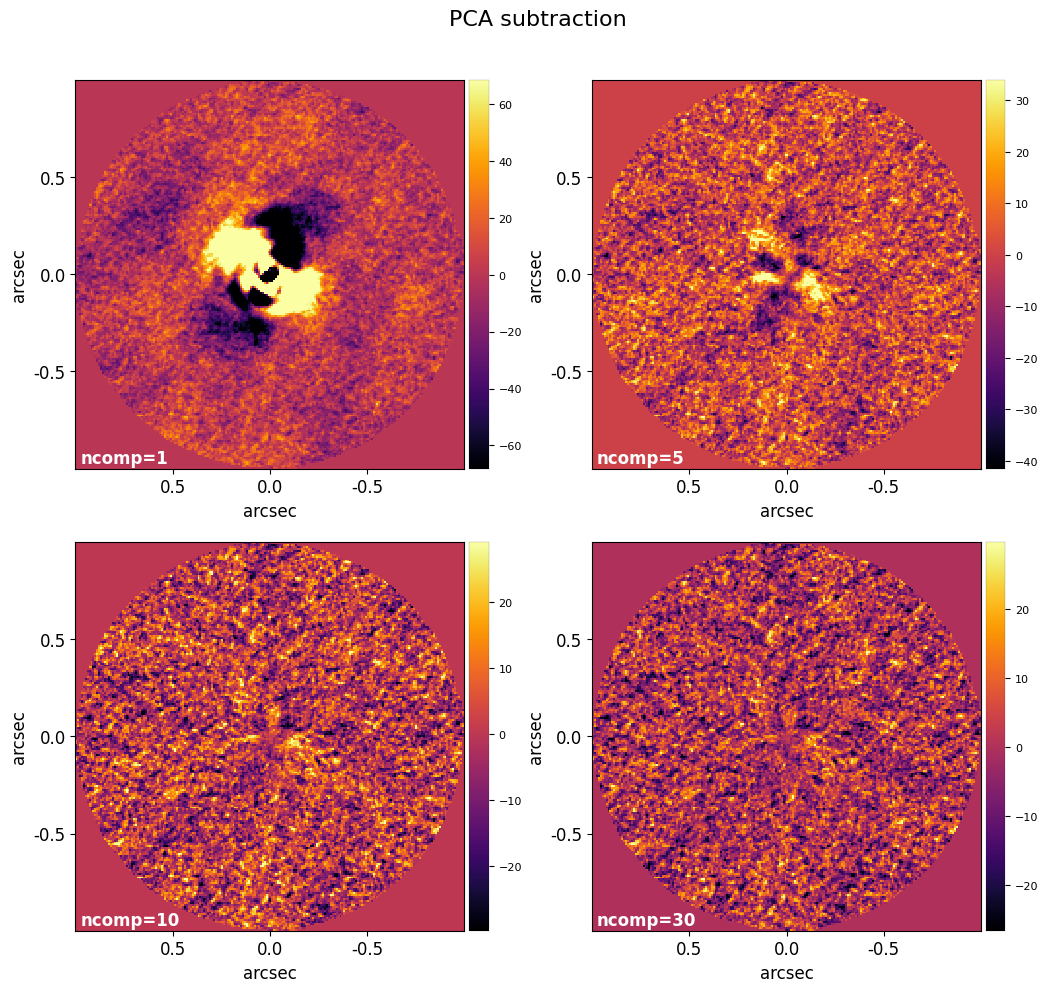

In [24]:
plot_frames(
    pca_residual_frames[[1, 5, 10, 30]]...;
    zscale=true, title="PCA subtraction", rows=2,
    label=("ncomp=1", "ncomp=5", "ncomp=10", "ncomp=30")
)

In [25]:
stim_av, slimmask = slimmap(pca_residual_cubes, angles, N = ceil(Int, π * fwhm^2))
slim_prob_map = stim_av .* slimmask;

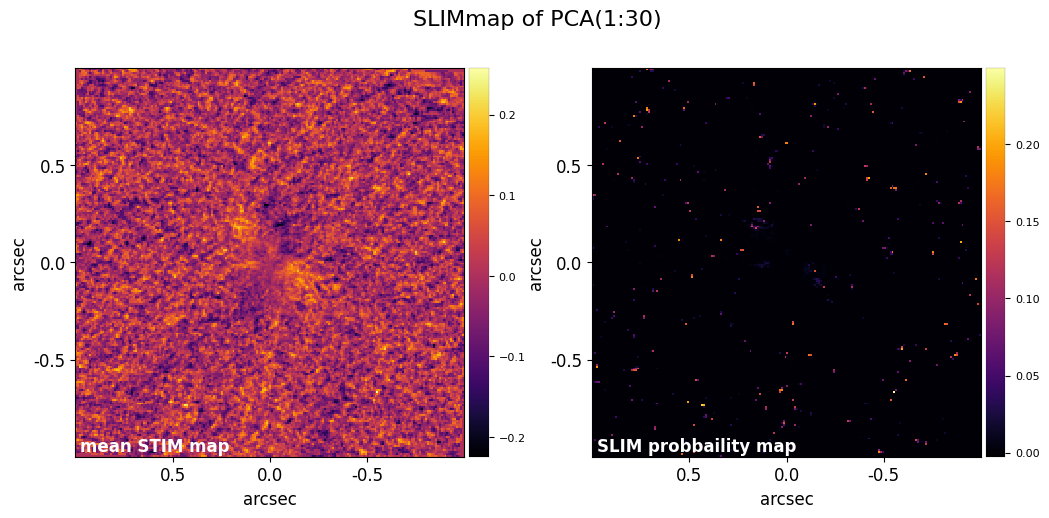

In [26]:
plot_frames(
    stim_av, slim_prob_map;
    title="SLIMmap of PCA(1:$max_ncomp)", label=("mean STIM map", "SLIM probbaility map")
)

## Annular PCA subtraction

### without rotation threshold

In [27]:
ncomps_ann = [2, 4, 6, 10, fill(20, 7)...]
ann_pca_residual_cube = subtract(PCA.(ncomps_ann), ann_cube)
push!(results, :annular_pca => ann_pca_residual_cube);

In [28]:
ann_pca_residual = collapse(ann_pca_residual_cube, angles)
ann_pca_snr = detectionmap(ann_pca_residual, fwhm)
ann_pca_stim = stimmap(ann_pca_residual_cube, angles);

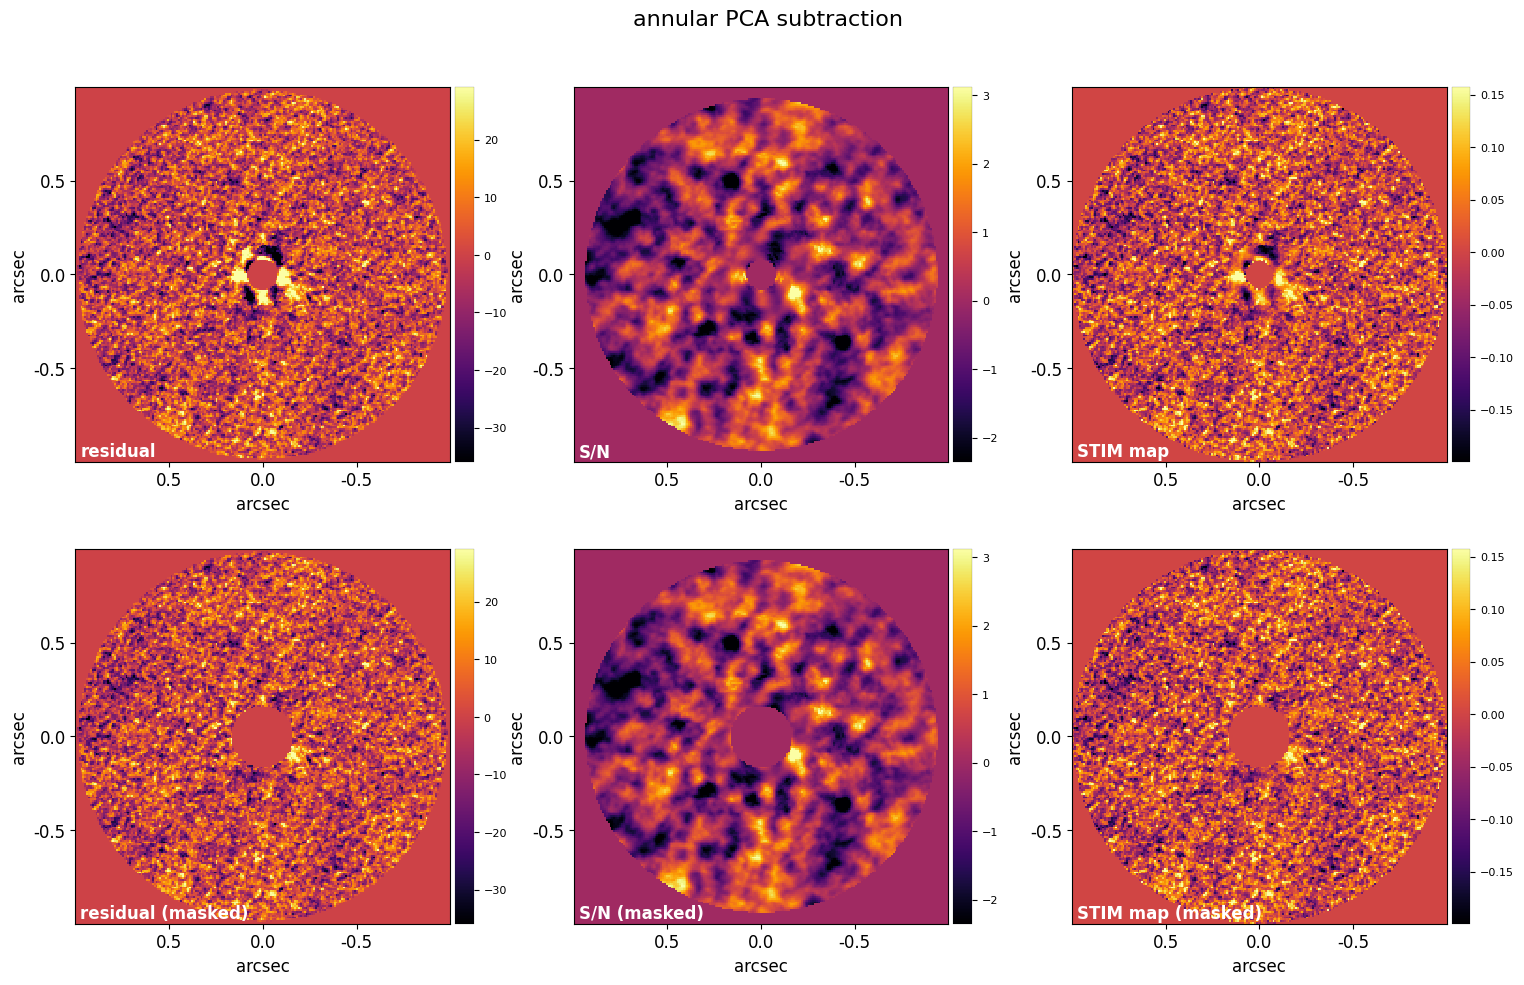

In [29]:
plot_frames(
    ann_pca_residual, ann_pca_snr, ann_pca_stim,
    mask_circle.((ann_pca_residual, ann_pca_snr, ann_pca_stim), 2 * fwhm)...;
    zscale=true, rows=2,
    title="annular PCA subtraction",
    label=("residual", "S/N", "STIM map",
           "residual (masked)", "S/N (masked)", "STIM map (masked)"),
)

### with rotation threshold

In [30]:
alg = Framewise(PCA.(ncomps_ann), delta_rot=1)
ann_pca_drot_residual_cube = subtract(alg, ann_cube; angles)
push!(results, :annular_pca_drot => ann_pca_drot_residual_cube);

┌ Info: pa threshold 36.86989764584402 too large, will be set to 36.173437216177774
└ @ ADI /Users/miles/.julia/packages/ADI/iopa7/src/framewise.jl:140


In [31]:
ann_pca_drot_residual = collapse(ann_pca_drot_residual_cube, angles)
ann_pca_drot_snr = detectionmap(ann_pca_drot_residual, fwhm)
ann_pca_drot_stim = stimmap(ann_pca_drot_residual_cube, angles);

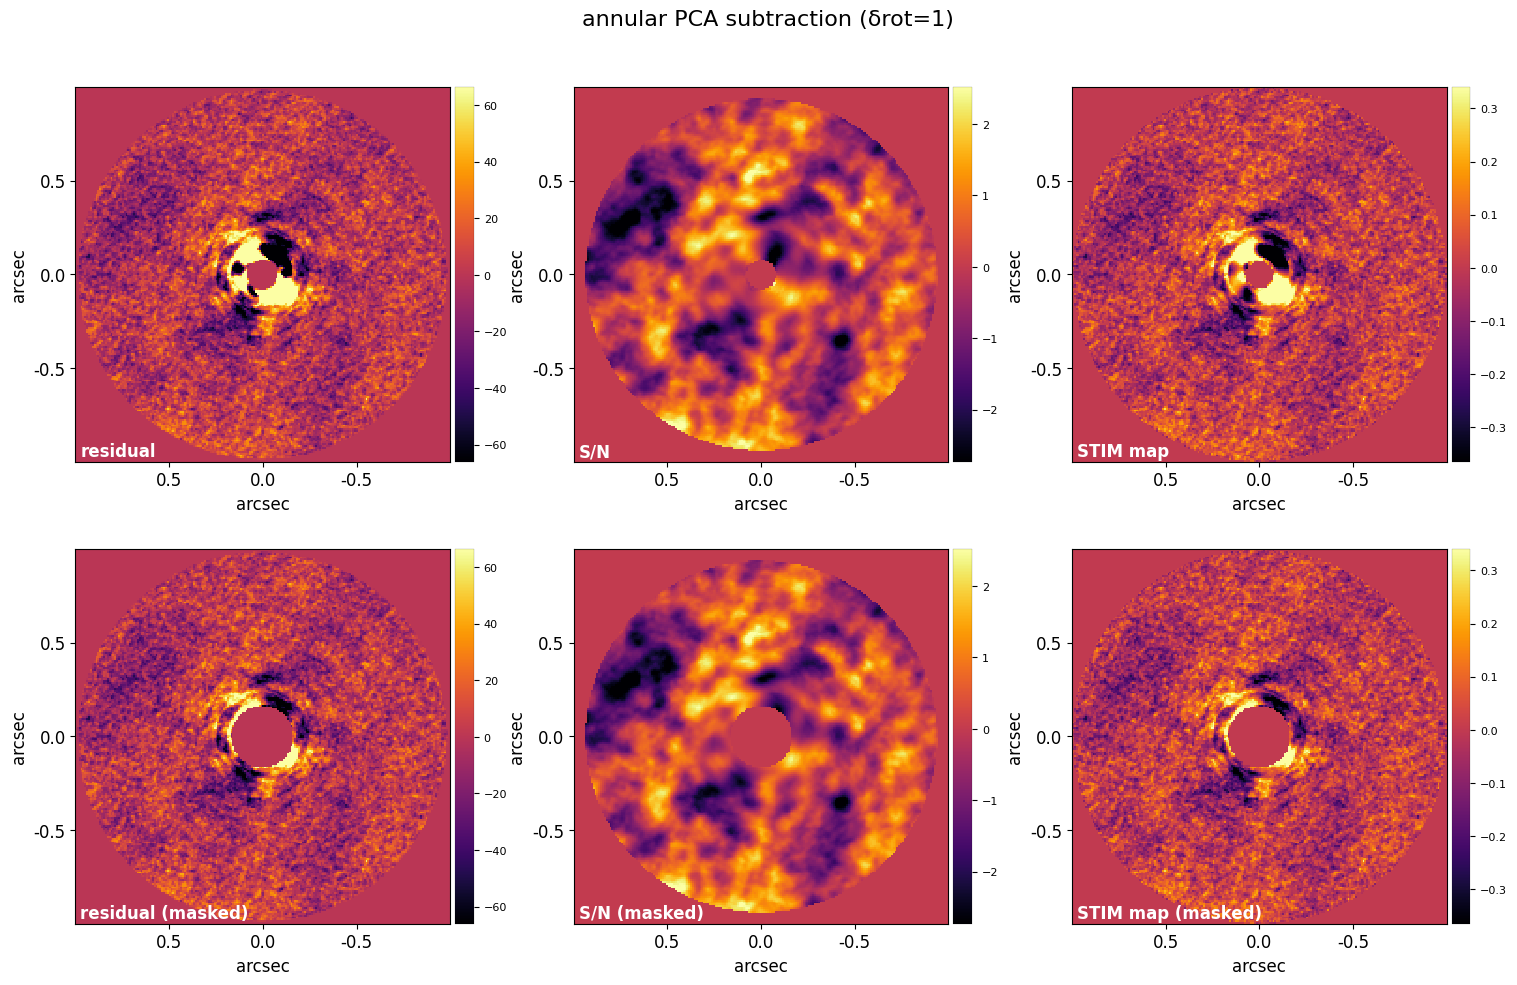

In [32]:
plot_frames(
    ann_pca_drot_residual, ann_pca_drot_snr, ann_pca_drot_stim,
    mask_circle.((ann_pca_drot_residual, ann_pca_drot_snr, ann_pca_drot_stim), 2 * fwhm)...;
    zscale=true, rows=2,
    title="annular PCA subtraction (δrot=1)",
    label=("residual", "S/N", "STIM map",
           "residual (masked)", "S/N (masked)", "STIM map (masked)"),
)

## GreeDS subtraction

In [33]:
max_ncomp_greeds = 20
# go down from 30 to 1 to get exponential speedup rather than slowdown
greeds_residual_cubes = @showprogress map(n -> subtract(GreeDS(n), cube; angles), max_ncomp_greeds:-1:1)
greeds_residual_frames = collapse.(greeds_residual_cubes, Ref(angles));

Progress: 100%|█████████████████████████████████████████| Time: 0:21:29


In [43]:
DS9.set(permutedims(cat(greeds_residual_frames..., dims=3), (2, 1, 3)))

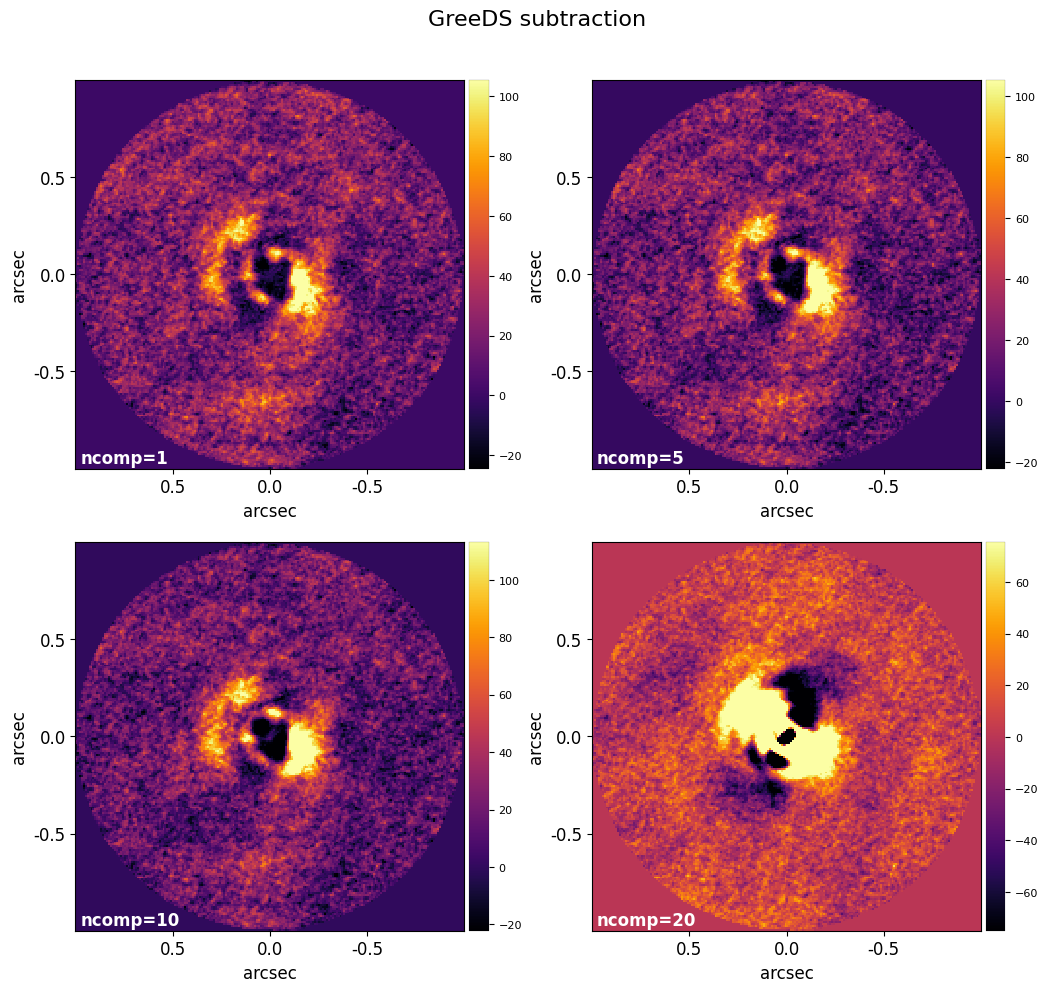

In [35]:
plot_frames(
    greeds_residual_frames[[1, 5, 10, 20]]...;
    zscale=true, title="GreeDS subtraction", rows=2,
    label=("ncomp=1", "ncomp=5", "ncomp=10", "ncomp=20")
)

In [36]:
stim_av_greeds, slimmask_greeds = slimmap(greeds_residual_cubes, angles, N = ceil(Int, π * fwhm^2))
slim_prob_map_greeds = stim_av_greeds .* slimmask_greeds;

In [47]:
DS9.set(collect(slim_prob_map_greeds'))

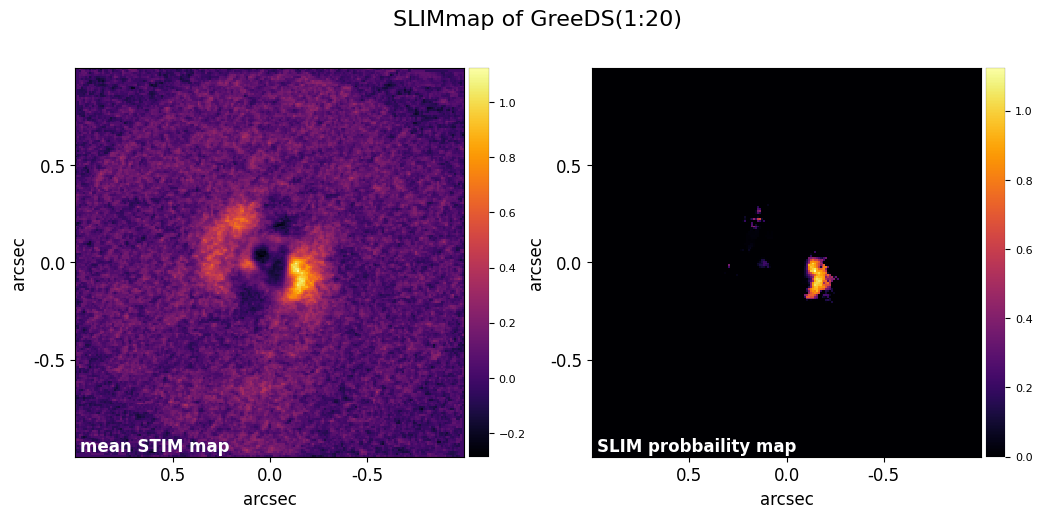

In [37]:
plot_frames(
    stim_av_greeds, slim_prob_map_greeds;
    title="SLIMmap of GreeDS(1:$max_ncomp_greeds)", label=("mean STIM map", "SLIM probbaility map"),
)

## Contrast Curves

In [38]:
cc_med = contrast_curve(Classic(), cube, angles, psf_model; fwhm, nbranch=6) |> DataFrame;

┌ Info: Calculating Throughput
└ @ ADI.Metrics /Users/miles/.julia/packages/ADI/iopa7/src/metrics/contrast.jl:58


In [39]:
cc_pca_2 = contrast_curve(PCA(2), cube, angles, psf_model; fwhm, nbranch=6) |> DataFrame
cc_pca_4 = contrast_curve(PCA(4), cube, angles, psf_model; fwhm, nbranch=6) |> DataFrame
cc_pca_9 = contrast_curve(PCA(9), cube, angles, psf_model; fwhm, nbranch=6) |> DataFrame;

┌ Info: Calculating Throughput
└ @ ADI.Metrics /Users/miles/.julia/packages/ADI/iopa7/src/metrics/contrast.jl:58
┌ Info: Calculating Throughput
└ @ ADI.Metrics /Users/miles/.julia/packages/ADI/iopa7/src/metrics/contrast.jl:58
┌ Info: Calculating Throughput
└ @ ADI.Metrics /Users/miles/.julia/packages/ADI/iopa7/src/metrics/contrast.jl:58


In [40]:
cc_greeds_4 = contrast_curve(GreeDS(4), cube, angles, psf_model; fwhm, angles, nbranch=6) |> DataFrame
cc_greeds_10 = contrast_curve(GreeDS(10), cube, angles, psf_model; fwhm, angles, nbranch=6) |> DataFrame;

┌ Info: Calculating Throughput
└ @ ADI.Metrics /Users/miles/.julia/packages/ADI/iopa7/src/metrics/contrast.jl:58
┌ Info: Calculating Throughput
└ @ ADI.Metrics /Users/miles/.julia/packages/ADI/iopa7/src/metrics/contrast.jl:58


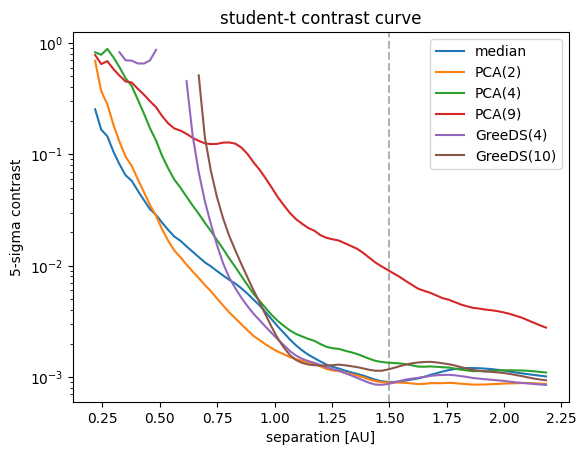

In [41]:
semilogy(cc_med.distance .* auscale, cc_med.contrast_corr, label="median")
semilogy(cc_pca_2.distance .* auscale, cc_pca_2.contrast_corr, label="PCA(2)")
semilogy(cc_pca_4.distance .* auscale, cc_pca_4.contrast_corr, label="PCA(4)")
semilogy(cc_pca_9.distance .* auscale, cc_pca_9.contrast_corr, label="PCA(9)")
semilogy(cc_greeds_4.distance .* auscale, cc_greeds_4.contrast_corr, label="GreeDS(4)")
semilogy(cc_greeds_10.distance .* auscale, cc_greeds_10.contrast_corr, label="GreeDS(10)")
ylims = ylim()
vlines(1.5, ylims..., color="k", linestyle="--", alpha=0.3)
ylim(ylims...)
legend()
xlabel("separation [AU]")
ylabel("5-sigma contrast")
title("student-t contrast curve");

In [42]:
cc_med |> CSV.write(procdir("2020nov28_contrast-curve_median.csv"))
cc_pca_2 |> CSV.write(procdir("2020nov28_contrast-curve_PCA-2.csv"))
cc_pca_4 |> CSV.write(procdir("2020nov28_contrast-curve_PCA-4.csv"))
cc_pca_9 |> CSV.write(procdir("2020nov28_contrast-curve_PCA-9.csv"))
cc_greeds_4 |> CSV.write(procdir("2020nov28_contrast-curve_GreeDS-4.csv"))
cc_greeds_10 |> CSV.write(procdir("2020nov28_contrast-curve_GreeDS-10.csv"));